# Plot data

We plot colony growth rate of Staph-Pseudomonas co-cultures on agar-pads and analyze dependance on space

Note: SA1 is GFP strain / SA2 is RFP strain

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#path handling
import pathlib

--- 

## 1. Load data

In [2]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
data_name = "20230411"

#read data
csv_name = path_data_files / "all_data_filtered.csv"
df_filtered = pd.read_csv(csv_name, index_col=0)

#set settings
dt_frames = 3/60 #time between frames in hours 


---

## 3. Analyze growth rate over time

Now that we have clean trajectories we can calculate the growth rates, by using a moving window to locally fit the log-area.
This gives the growth rate of the colony as function of time

In [9]:
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

fit_window = 11
df_filtered['mu'] = df_filtered.groupby('unique_id')['area'].rolling(fit_window, min_periods=6, center=True).apply(derivative, kwargs={'frm_interval':dt_frames, 'log':True}).reset_index(0,drop=True)

### 3.1 Colony growth rate as function of time

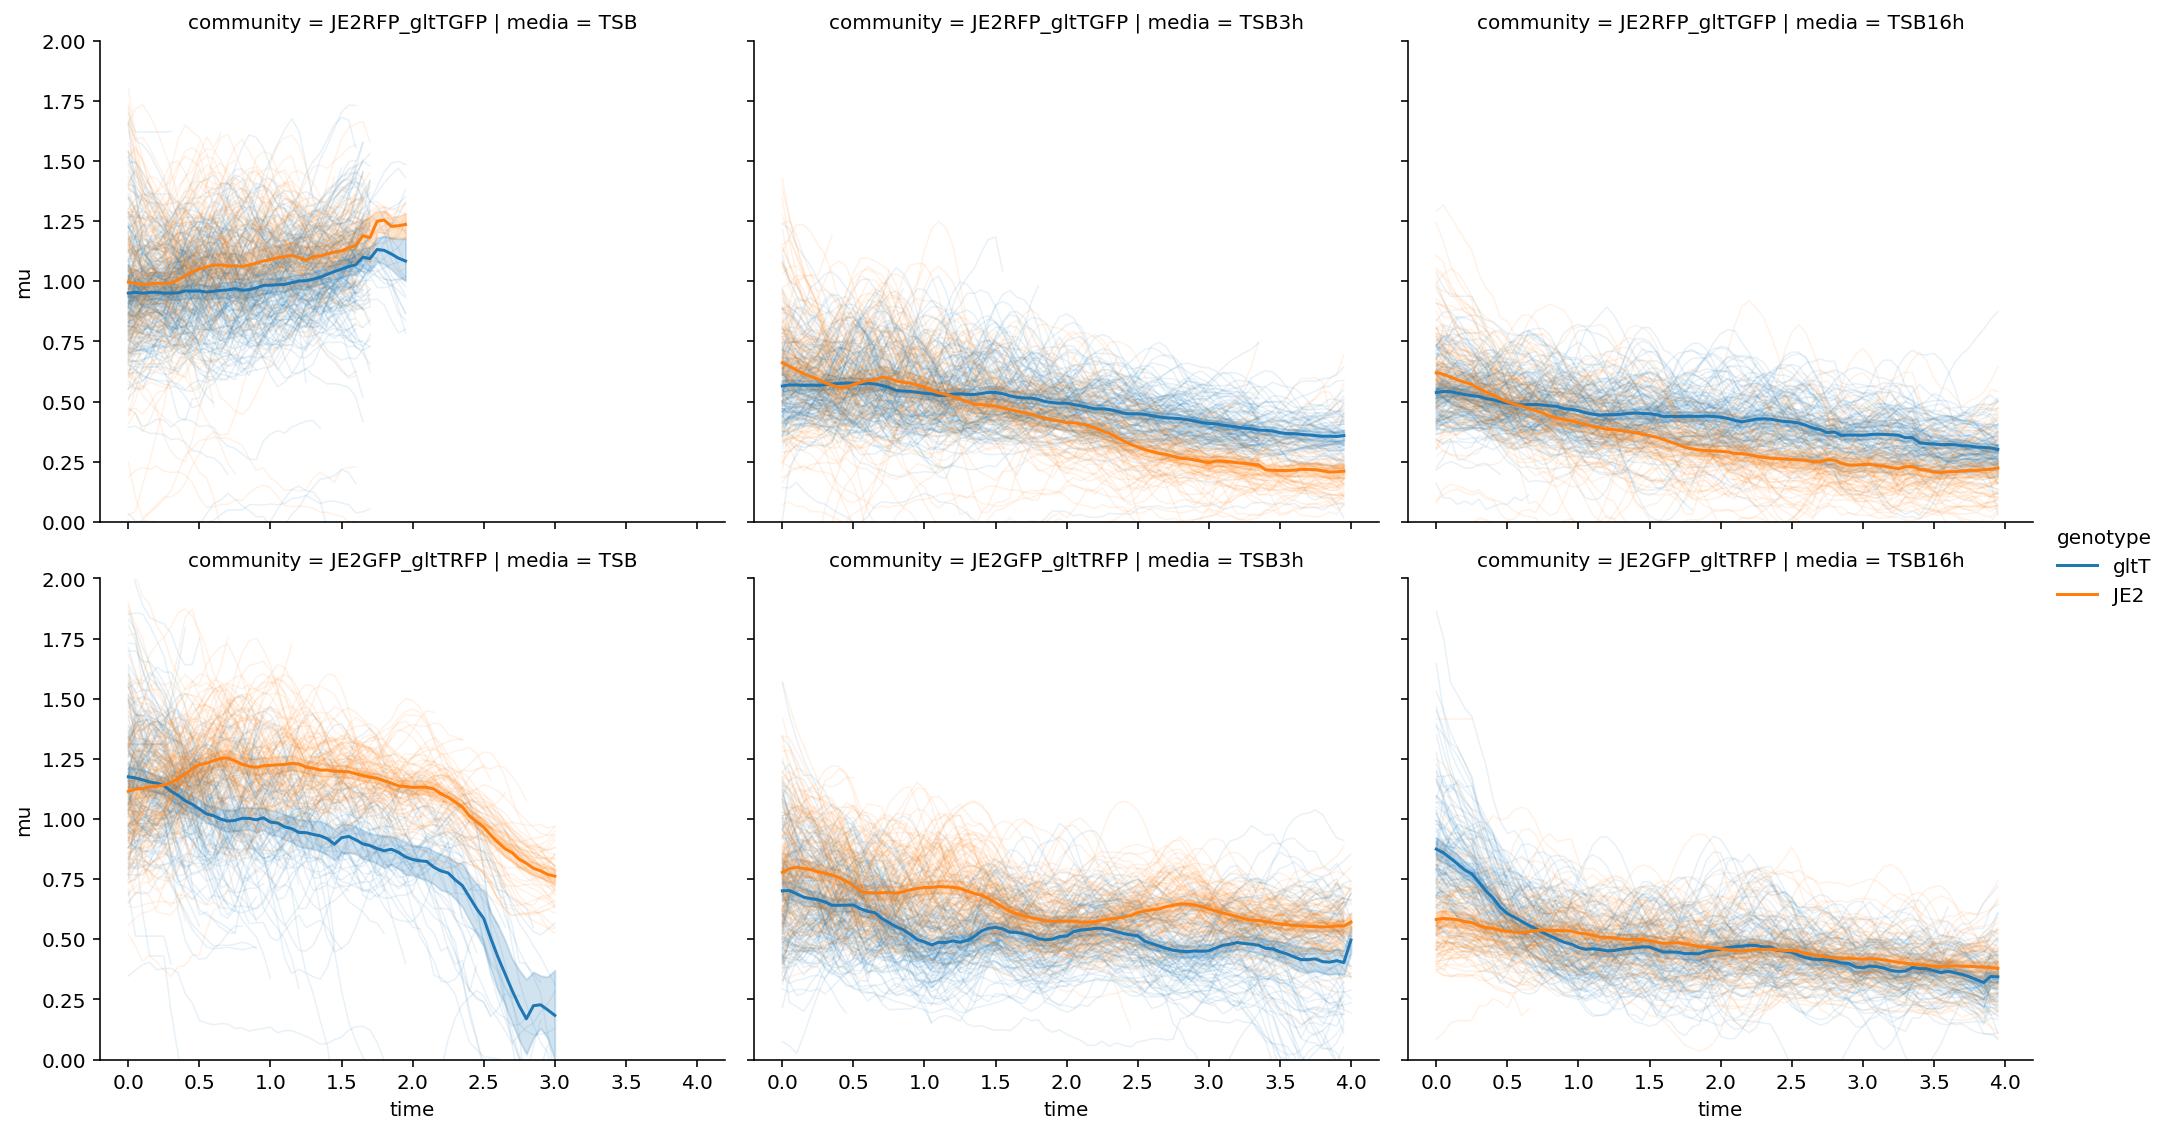

In [10]:
g = sns.FacetGrid(data=df_filtered, col='media',row='community',hue='genotype',aspect=1.2,height=4)
g.map_dataframe(sns.lineplot, x='time', y='mu', alpha=0.1,size=1,units='unique_id', estimator=None)
g.map_dataframe(sns.lineplot, x='time', y='mu').add_legend()

g.set(ylim=(0, 2))

---

## 4. Analyze growth rate over longer time periods

To avoid statistical dependence between data points we now calculate a single growth rate per colony, defined as `mu= log(area[t]/area[0])) / dt` where `area[t]` is the colony area after a defined time `t` and `area[0]` is the area at the start of the movie. We analyze the fist hour.

In [13]:
#set time points to analyze
t_analyze = 20 #t=1h

In [14]:
def summary_stats(x, period=10):
    '''create summary stats for each colony
    
    Parameters
    ----------
    x : pandas dataframe
        dataframe with colony data
    period : int
        number of frames to calculate stats over
    
    Returns
    -------
    d : Pandas Series
        Pandas series with summary stats
    '''
    
    #calculate growth rate
    start_area = x['area'].iloc[0]    
    end_area = x['area'].iloc[period] if x['area'].size > period else np.nan
    growth = np.log(end_area/start_area) / period

    d = {}
    #store growth rate
    d['area_start'] = start_area
    d['area_end'] = end_area
    d['growth'] = growth
    
    #for centroid take average over period
    d['centroid-0_av'] = x['centroid-0'].mean()
    d['centroid-1_av'] = x['centroid-1'].mean()
    
    #for distance measures try min, average, and start
    d['dist_PA_centroid_av'] = x['min_dist_PA_centroid'].mean()
    d['dist_PA_centroid_min'] = x['min_dist_PA_centroid'].min()
    d['dist_PA_centroid_start'] = x['min_dist_PA_centroid'].iloc[0]
    
    if 'min_dist_PA_edge2edge' in x.columns:
        d['dist_PA_edge2edge_av'] = x['min_dist_PA_edge2edge'].mean()
        d['dist_PA_edge2edge_min'] = x['min_dist_PA_edge2edge'].min()
        d['dist_PA_edge2edge_start'] = x['min_dist_PA_edge2edge'].iloc[0]
        
    #for metadata take first value    
    d['strain'] = x['strain'].iloc[0]
    d['condition'] = x['condition'].iloc[0]
    d['colony_id'] = x['colony_id'].iloc[0]
    d['unique_id'] = x['unique_id'].iloc[0]
    d['genotype'] = x['genotype'].iloc[0]
    d['marker'] = x['marker'].iloc[0]
    d['community'] = x['community'].iloc[0]
    d['media'] = x['media'].iloc[0]
    d['period' ] = period
        
    index = ['period','centroid-0_av', 'centroid-1_av', 
             'dist_PA_centroid_av', 'dist_PA_centroid_min', 'dist_PA_centroid_start', 
             'dist_PA_edge2edge_av', 'dist_PA_edge2edge_min', 'dist_PA_edge2edge_start',
             'area_start', 'area_end', 'growth',
             'strain', 'condition', 'colony_id', 'unique_id','media','community','genotype','marker']

    return pd.Series(d, index=index)

#create summary stats for each colony
dfList = [df_filtered.groupby('unique_id').apply(summary_stats, period=period).reset_index(drop=True) for period in t_analyze]
df_summary = pd.concat(dfList, axis=0, ignore_index=True)

### 4.1 Check overall growth rate

We first check the overall growth rate distributions.

First let's compare the two strain, we analyze a single time point (1h)

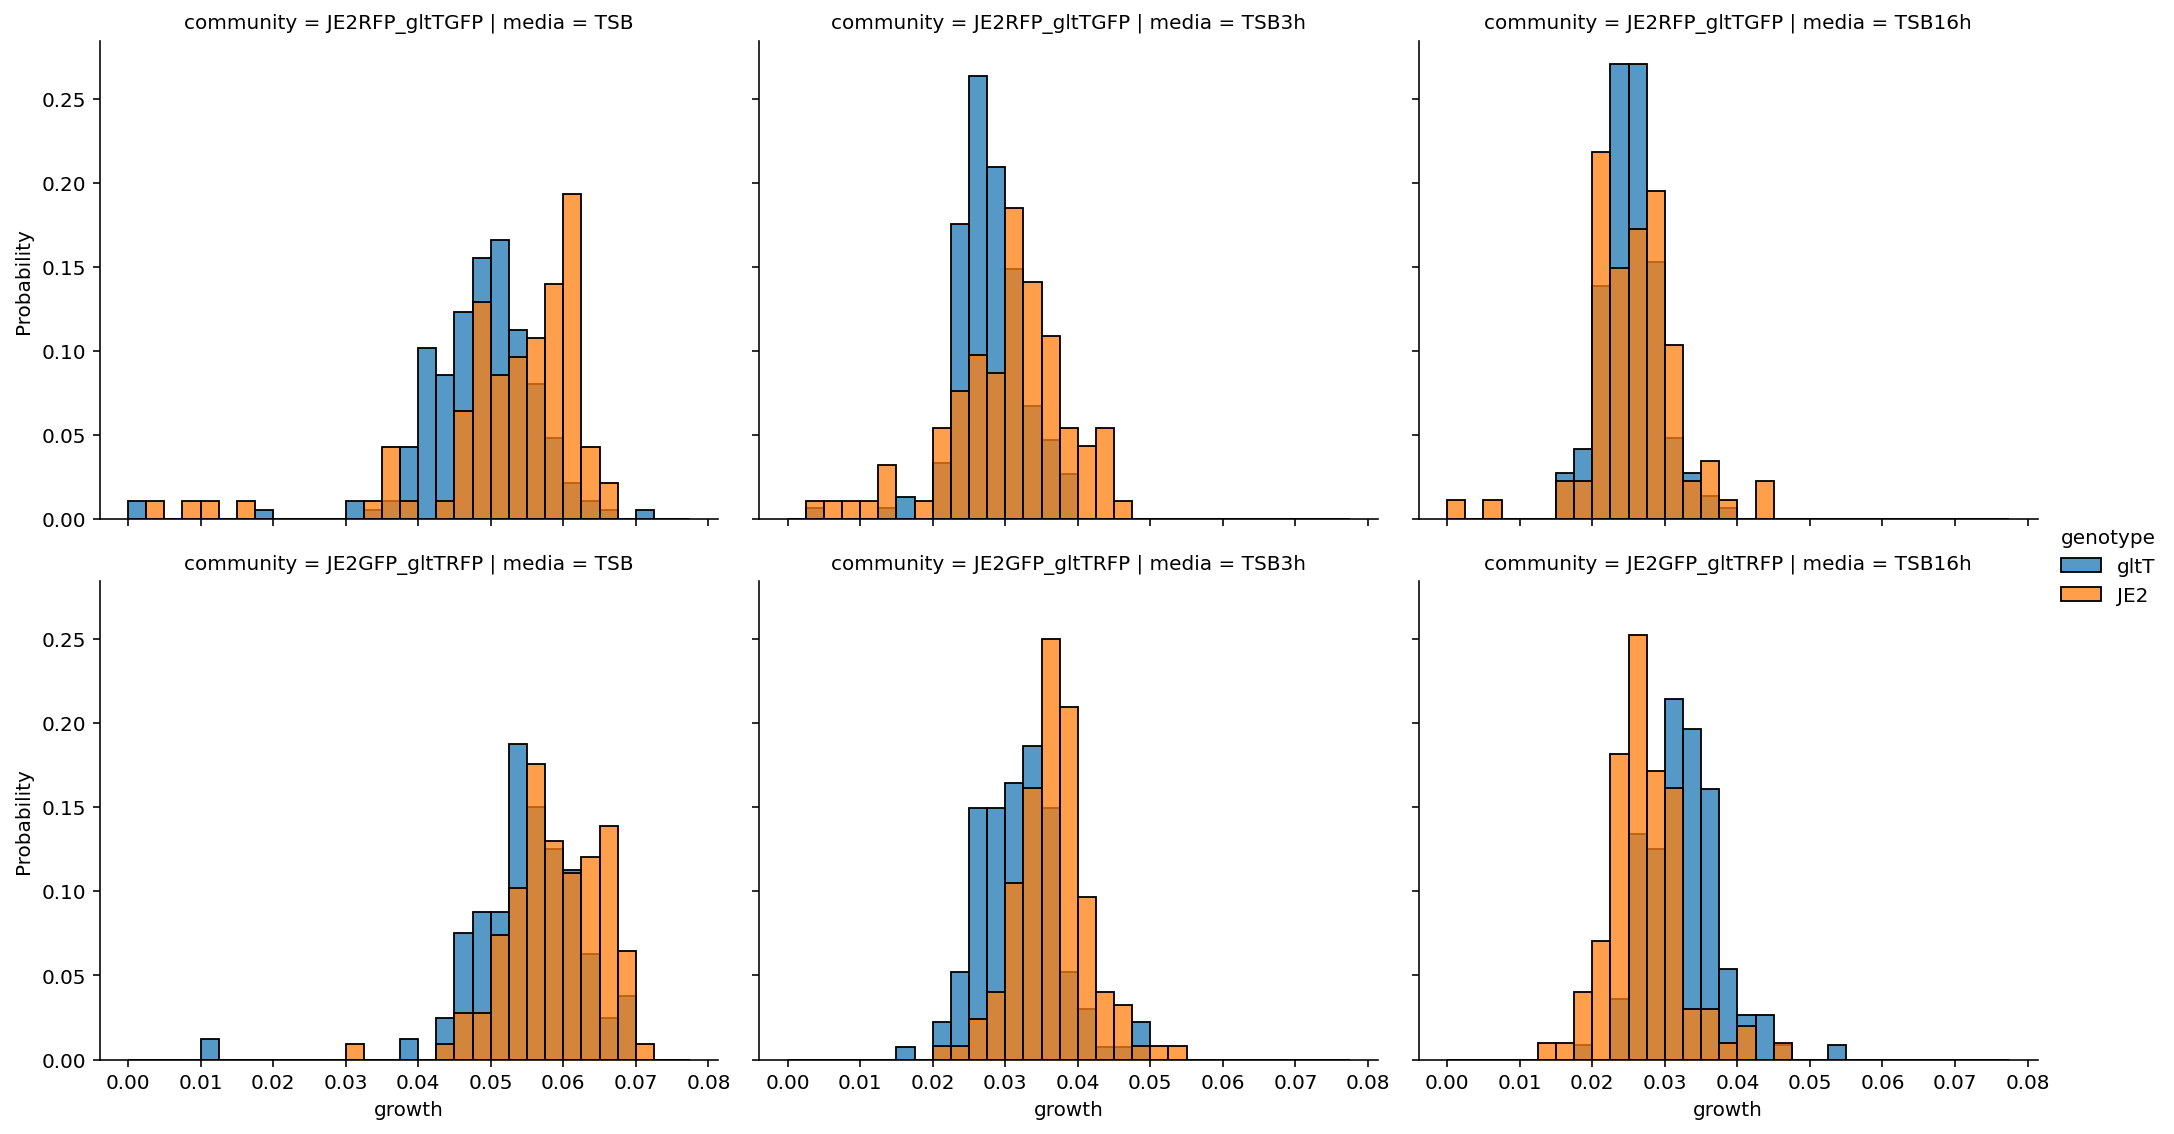

In [15]:
bins = np.arange(0,0.08,0.0025)
g = sns.FacetGrid(data=df_summary.loc[df_summary['period']==20], col='media',row='community',hue='genotype',aspect=1.2,height=4)
g.map_dataframe(sns.histplot, x='growth',common_norm=False, stat="probability", bins=bins).add_legend()

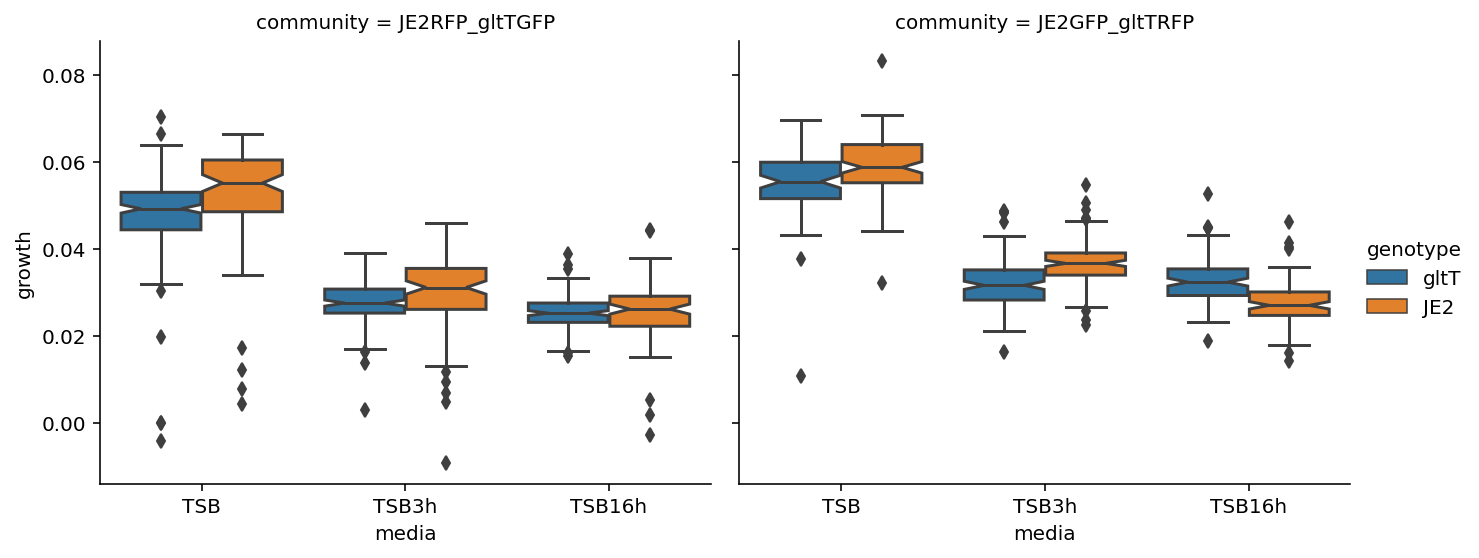

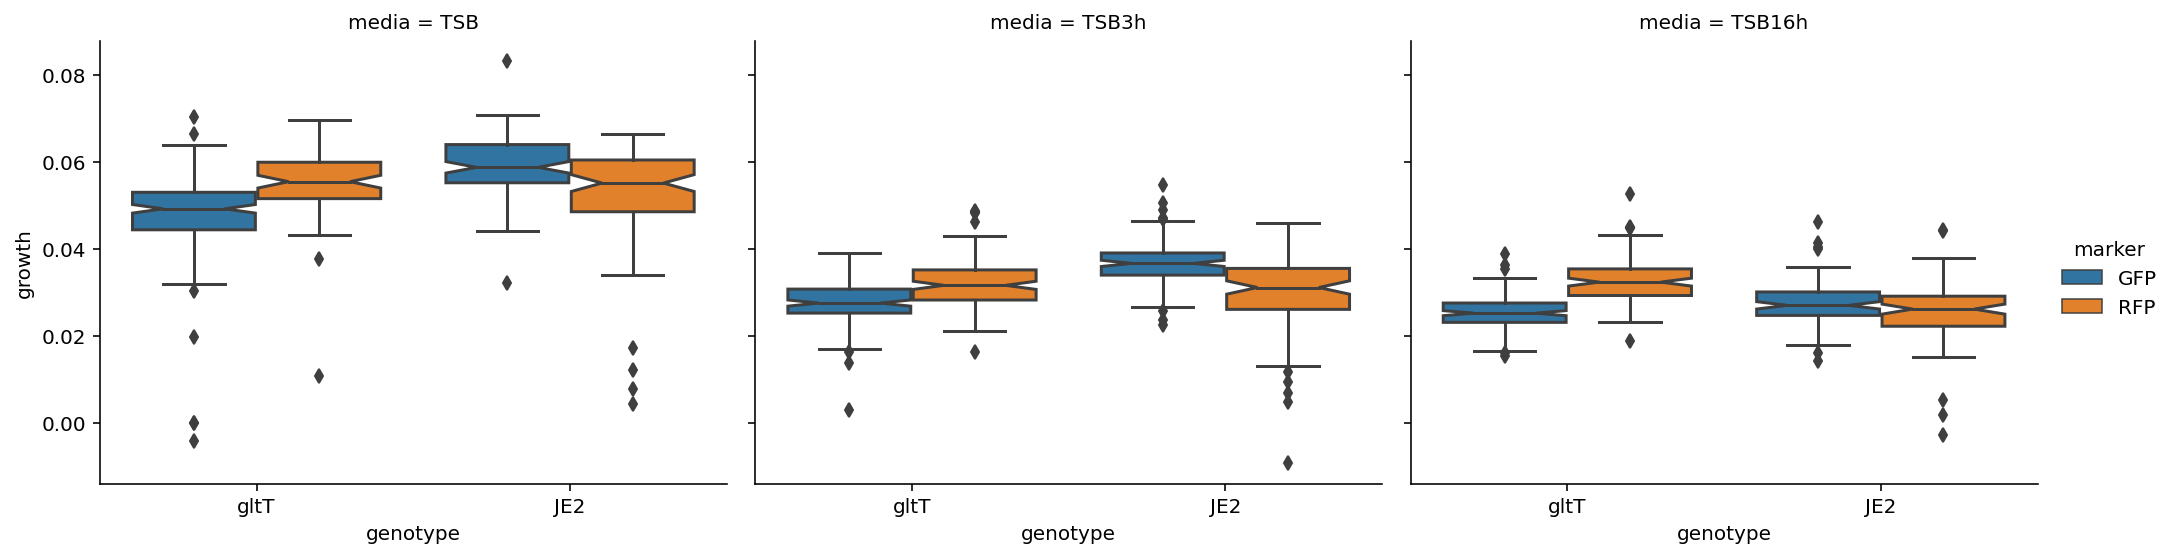

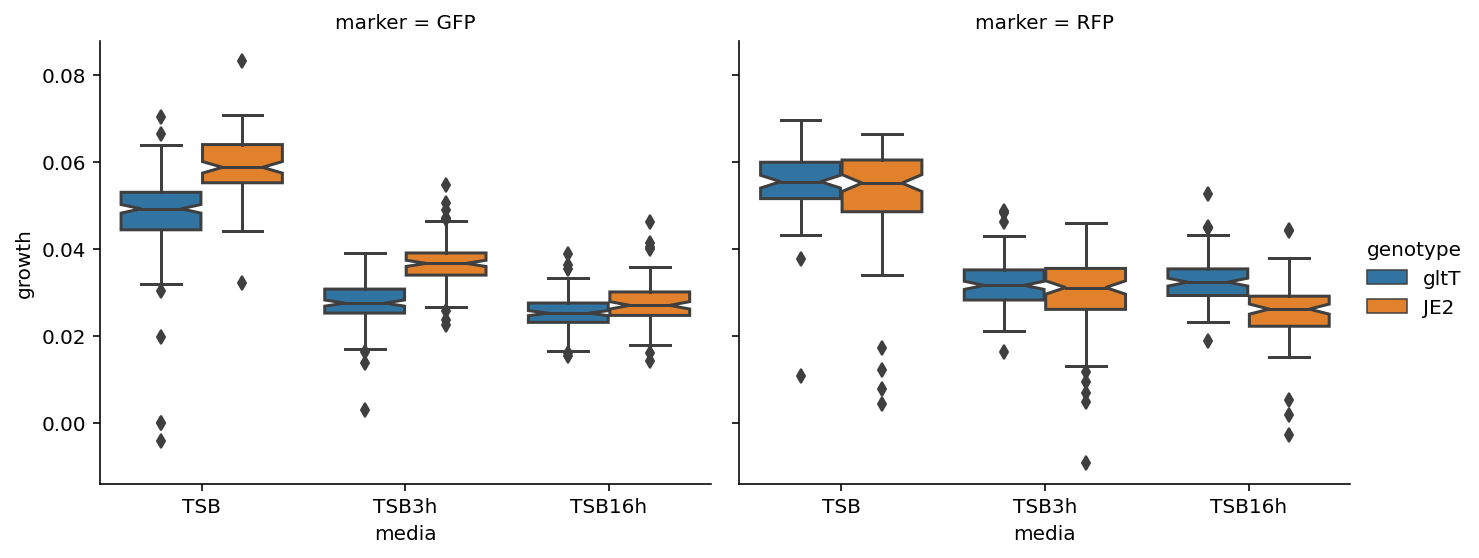

In [26]:
sns.catplot(data=df_summary.loc[df_summary['period']==20], y='growth',x='media',col='community',hue='genotype',aspect=1.2,height=4,kind='box',notch=True)
sns.catplot(data=df_summary.loc[df_summary['period']==20], y='growth',x='genotype',col='media',hue='marker',aspect=1.2,height=4,kind='box',notch=True)

sns.catplot(data=df_summary.loc[df_summary['period']==20], y='growth',x='media',col='marker',hue='genotype',aspect=1.2,height=4,kind='box',notch=True)

Next we compare the two markers

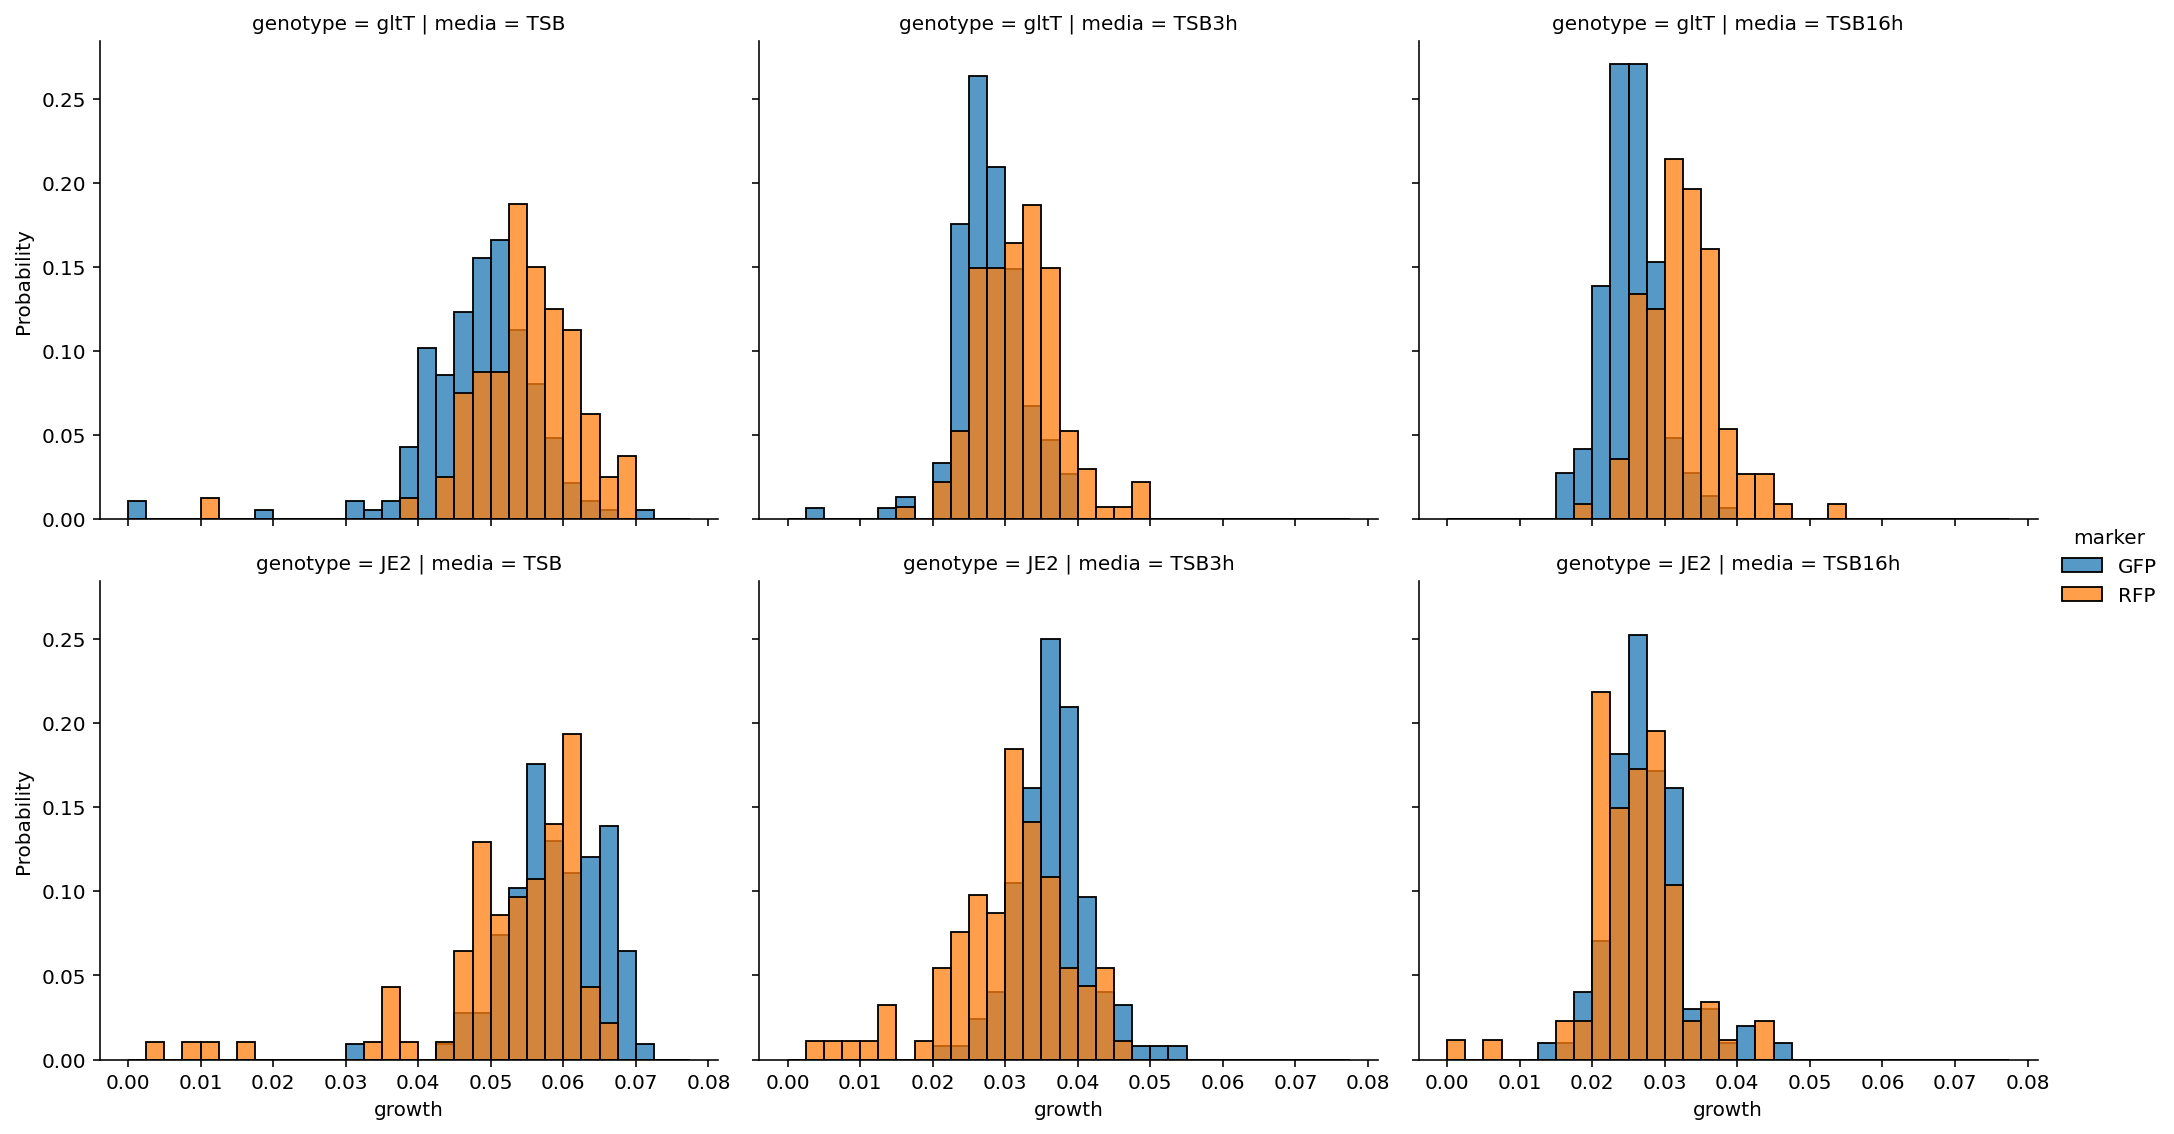

In [56]:
bins = np.arange(0,0.08,0.0025)
g = sns.FacetGrid(data=df_summary.loc[df_summary['period']==20], col='media',row='genotype',hue='marker',aspect=1.2,height=4)
g.map_dataframe(sns.histplot, x='growth',common_norm=False, stat="probability", 
                bins=bins, palette=['g','r']).add_legend()


### 4.2 Growth rate as function of space

We can now plot the colony growth rate (measured at different times) as function as the minimal distance to PA.

The distance between SA and PA colonies changes with time, we deal with this below by checking how growth rate correlates with the initial, minimal, and average distance (over time) to the nearest PA colony.

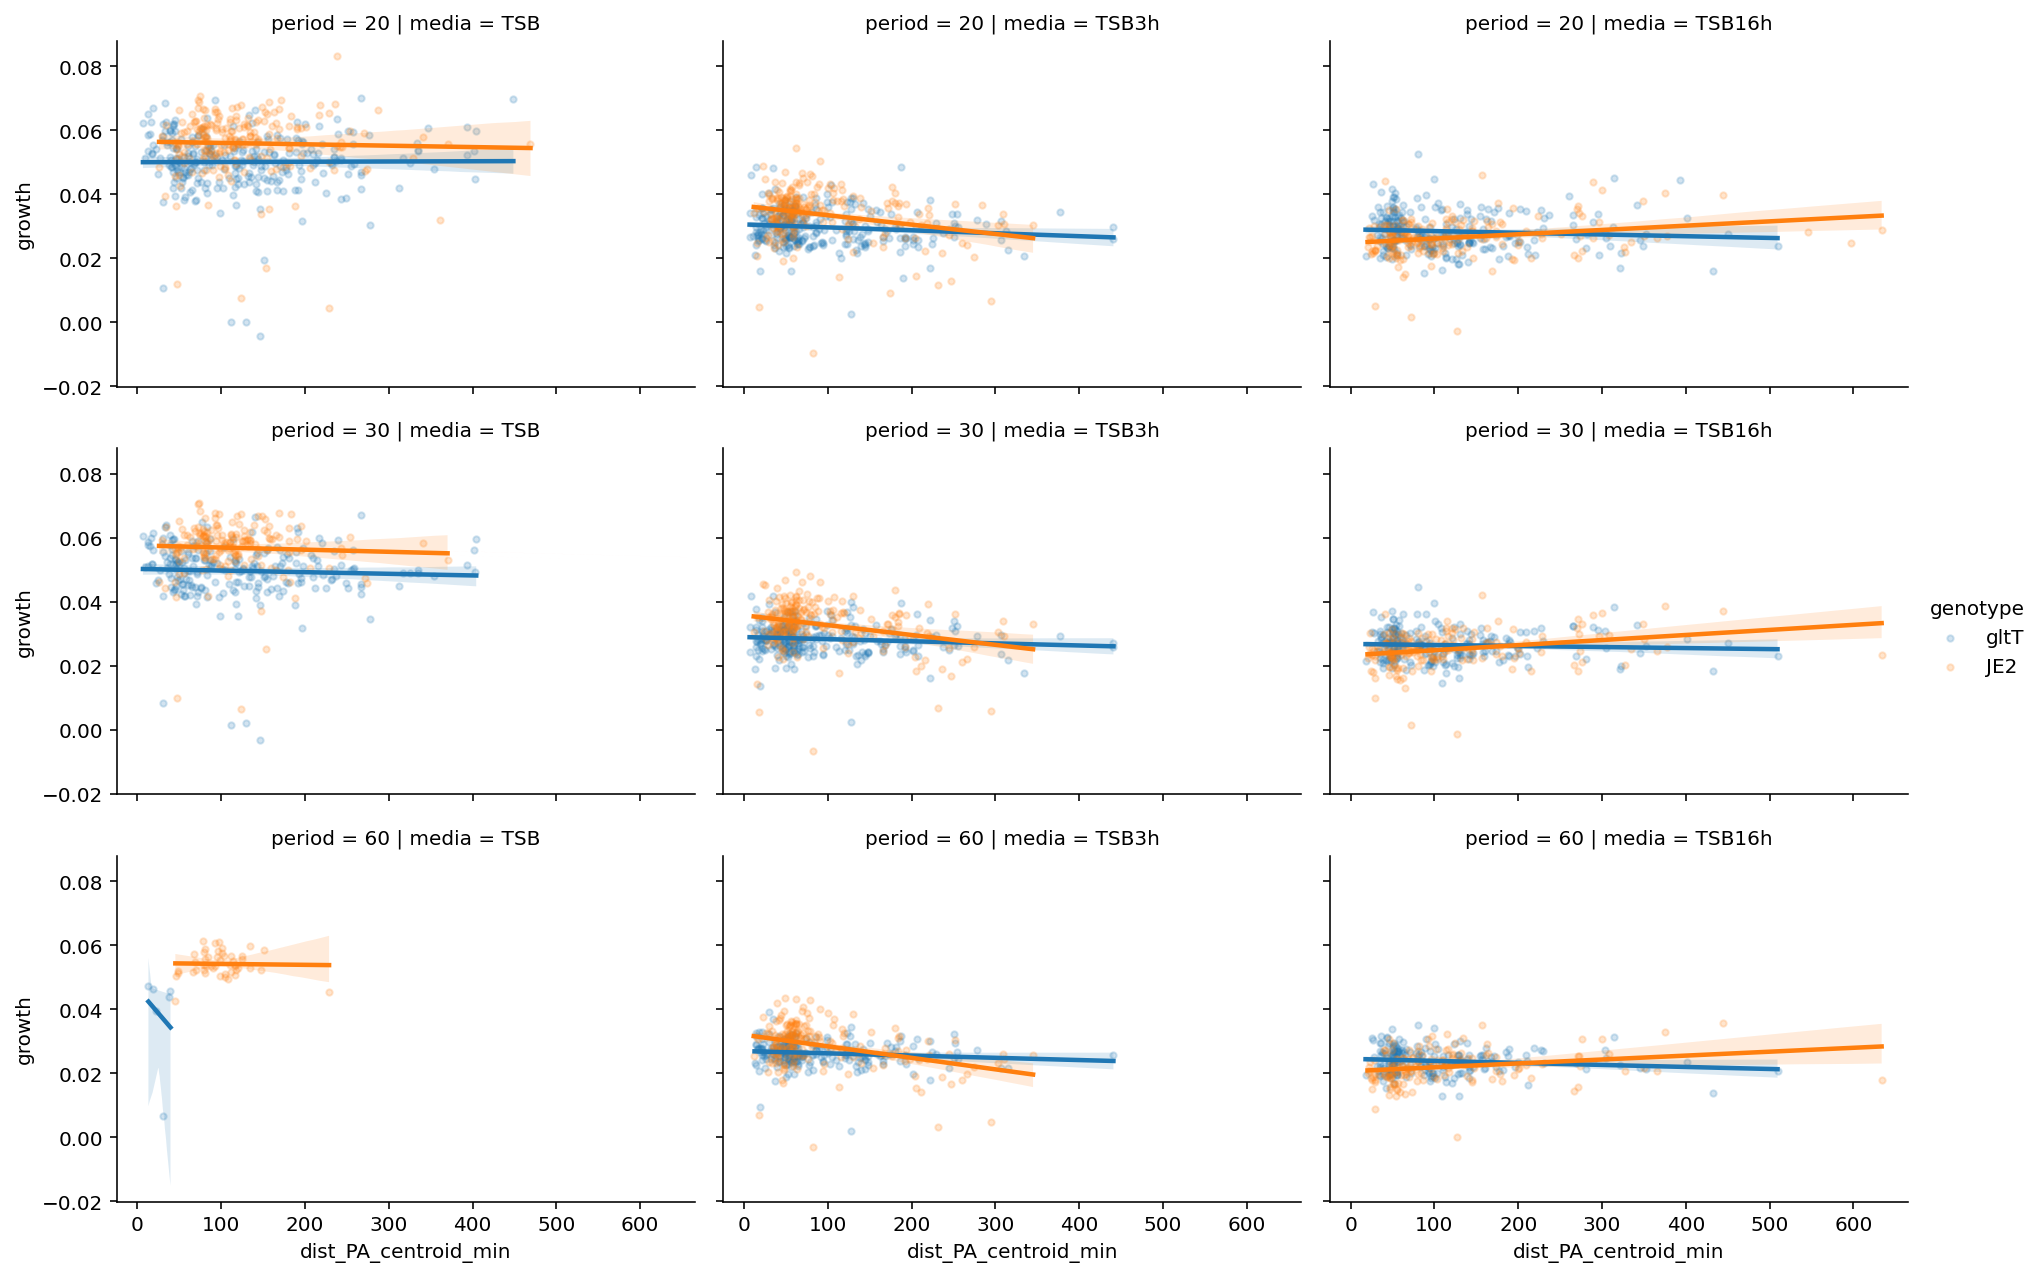

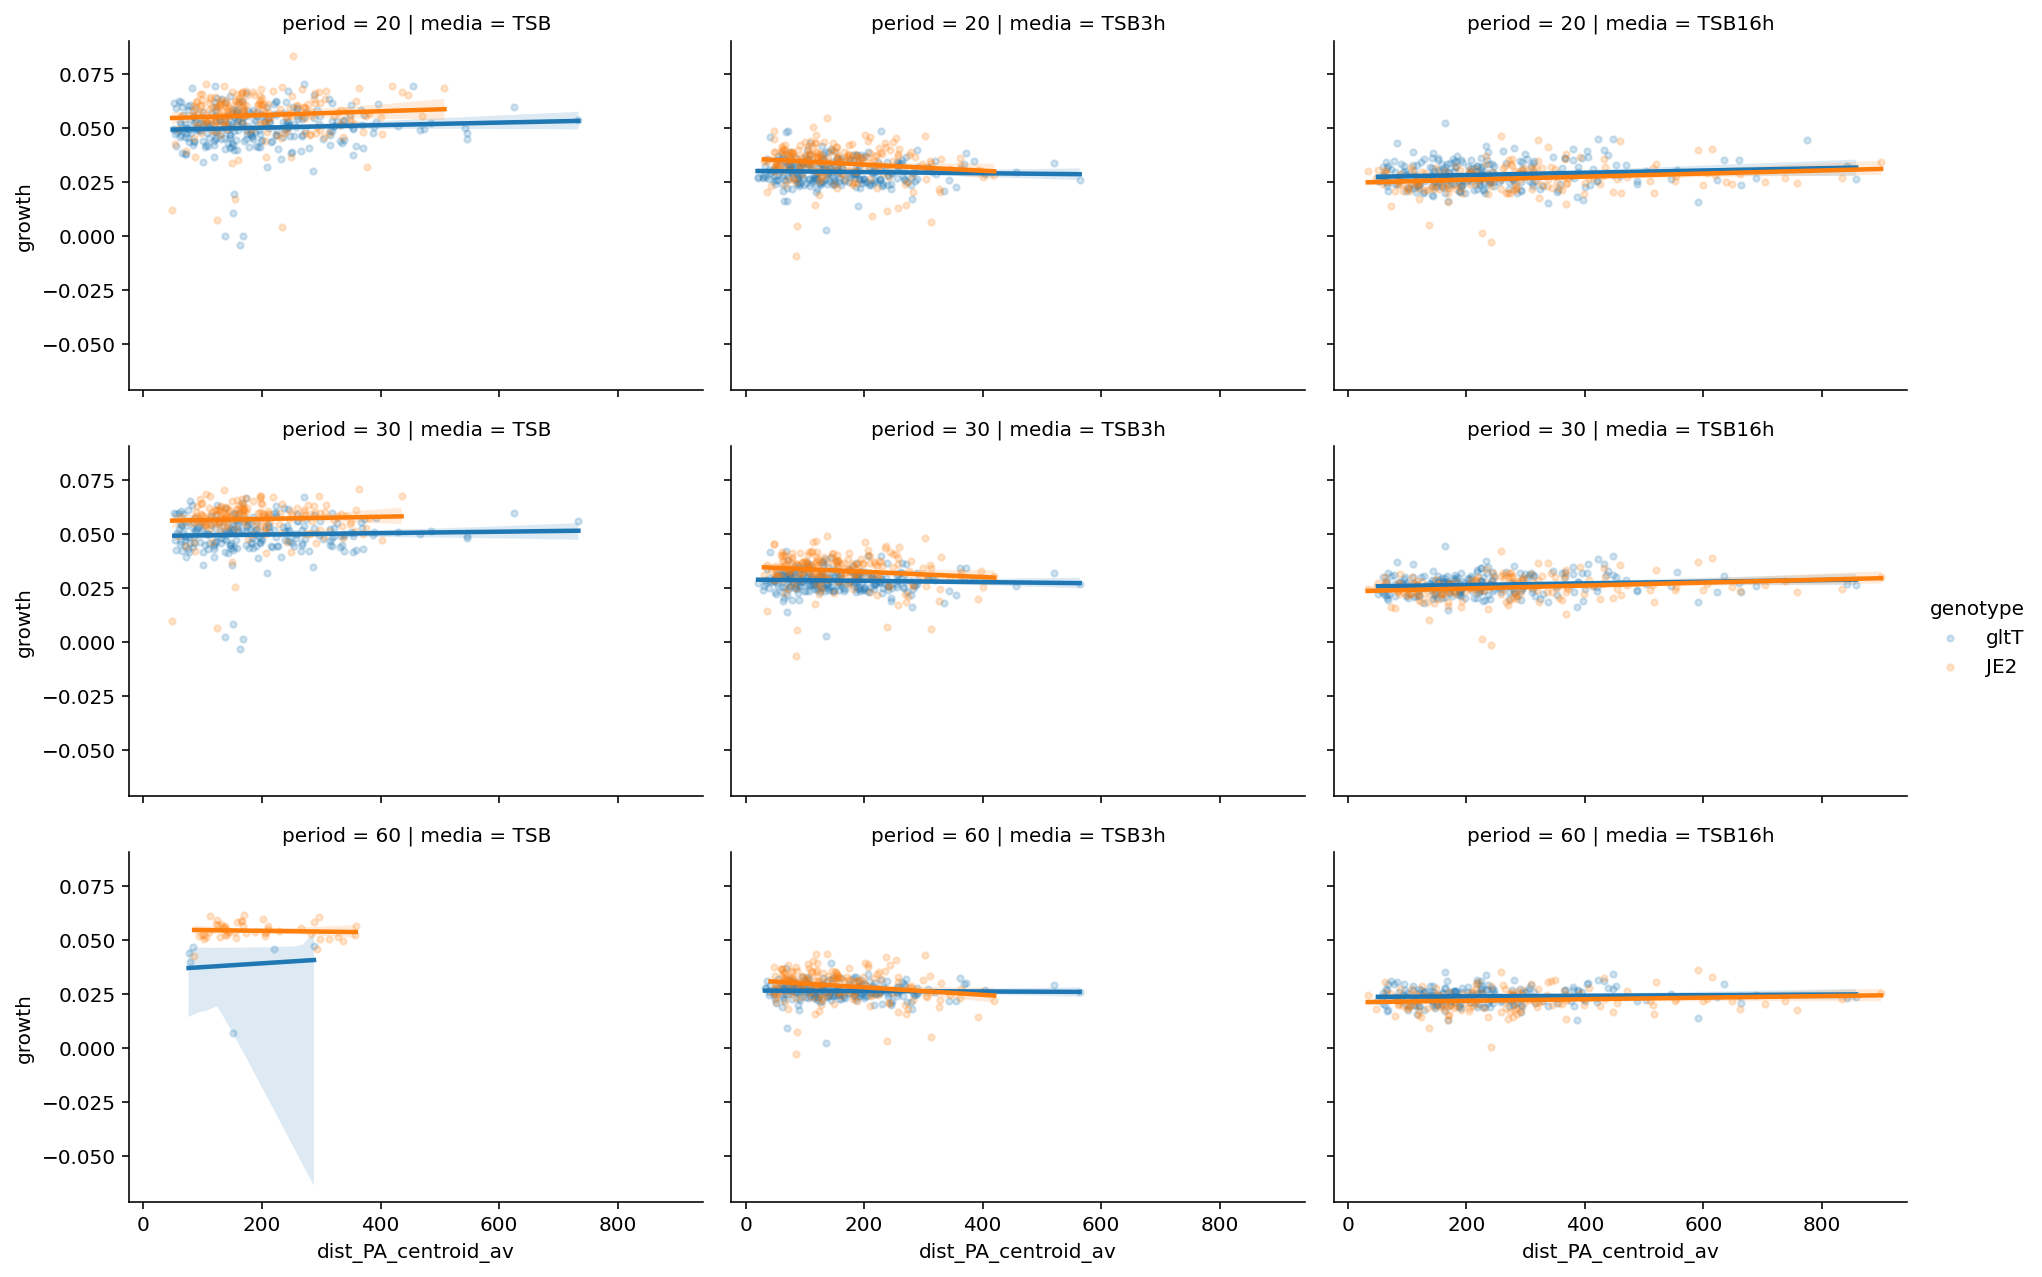

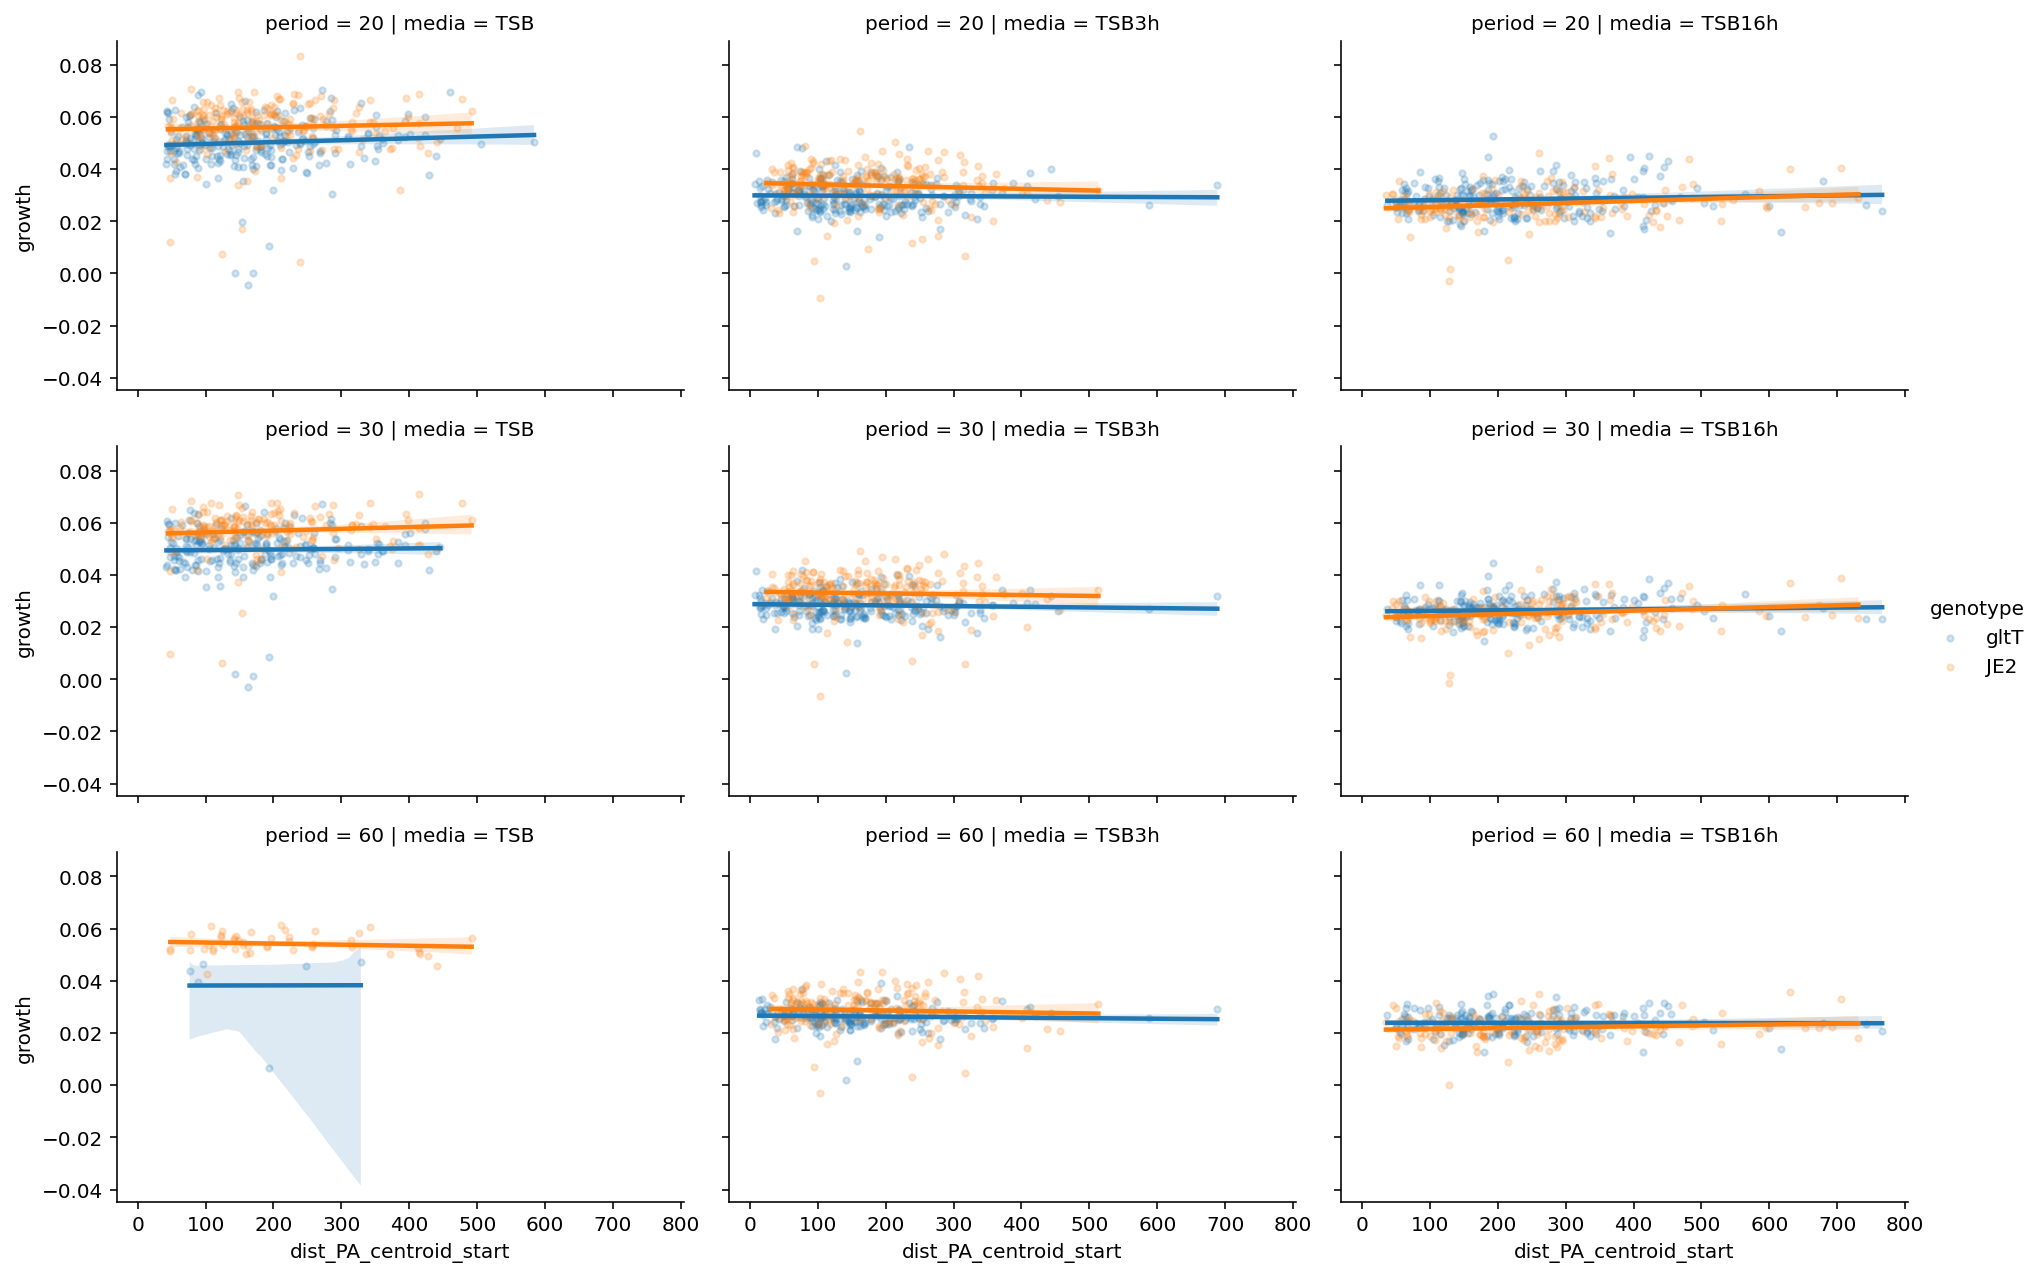

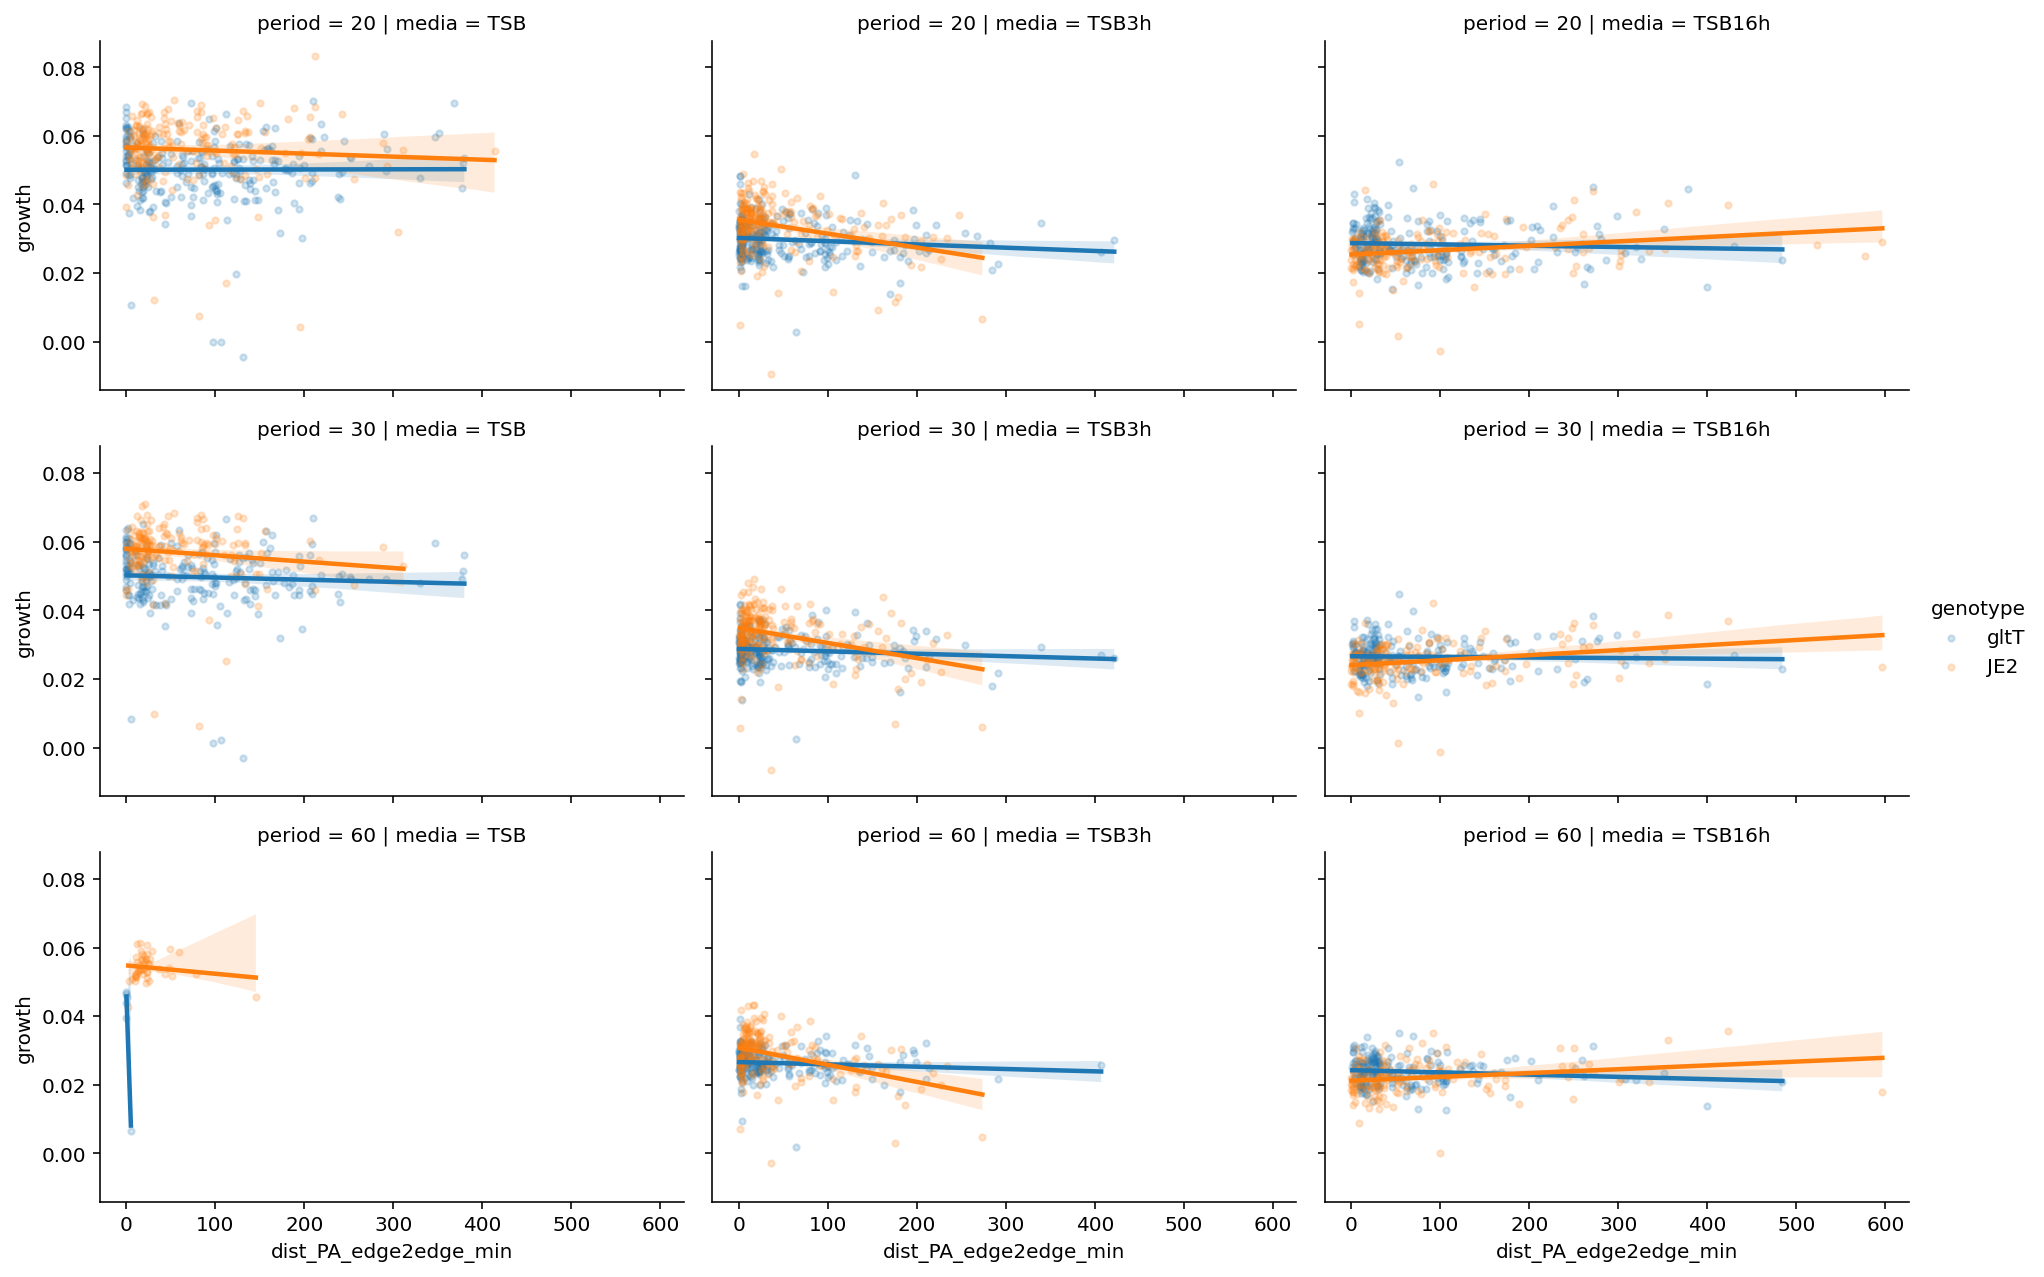

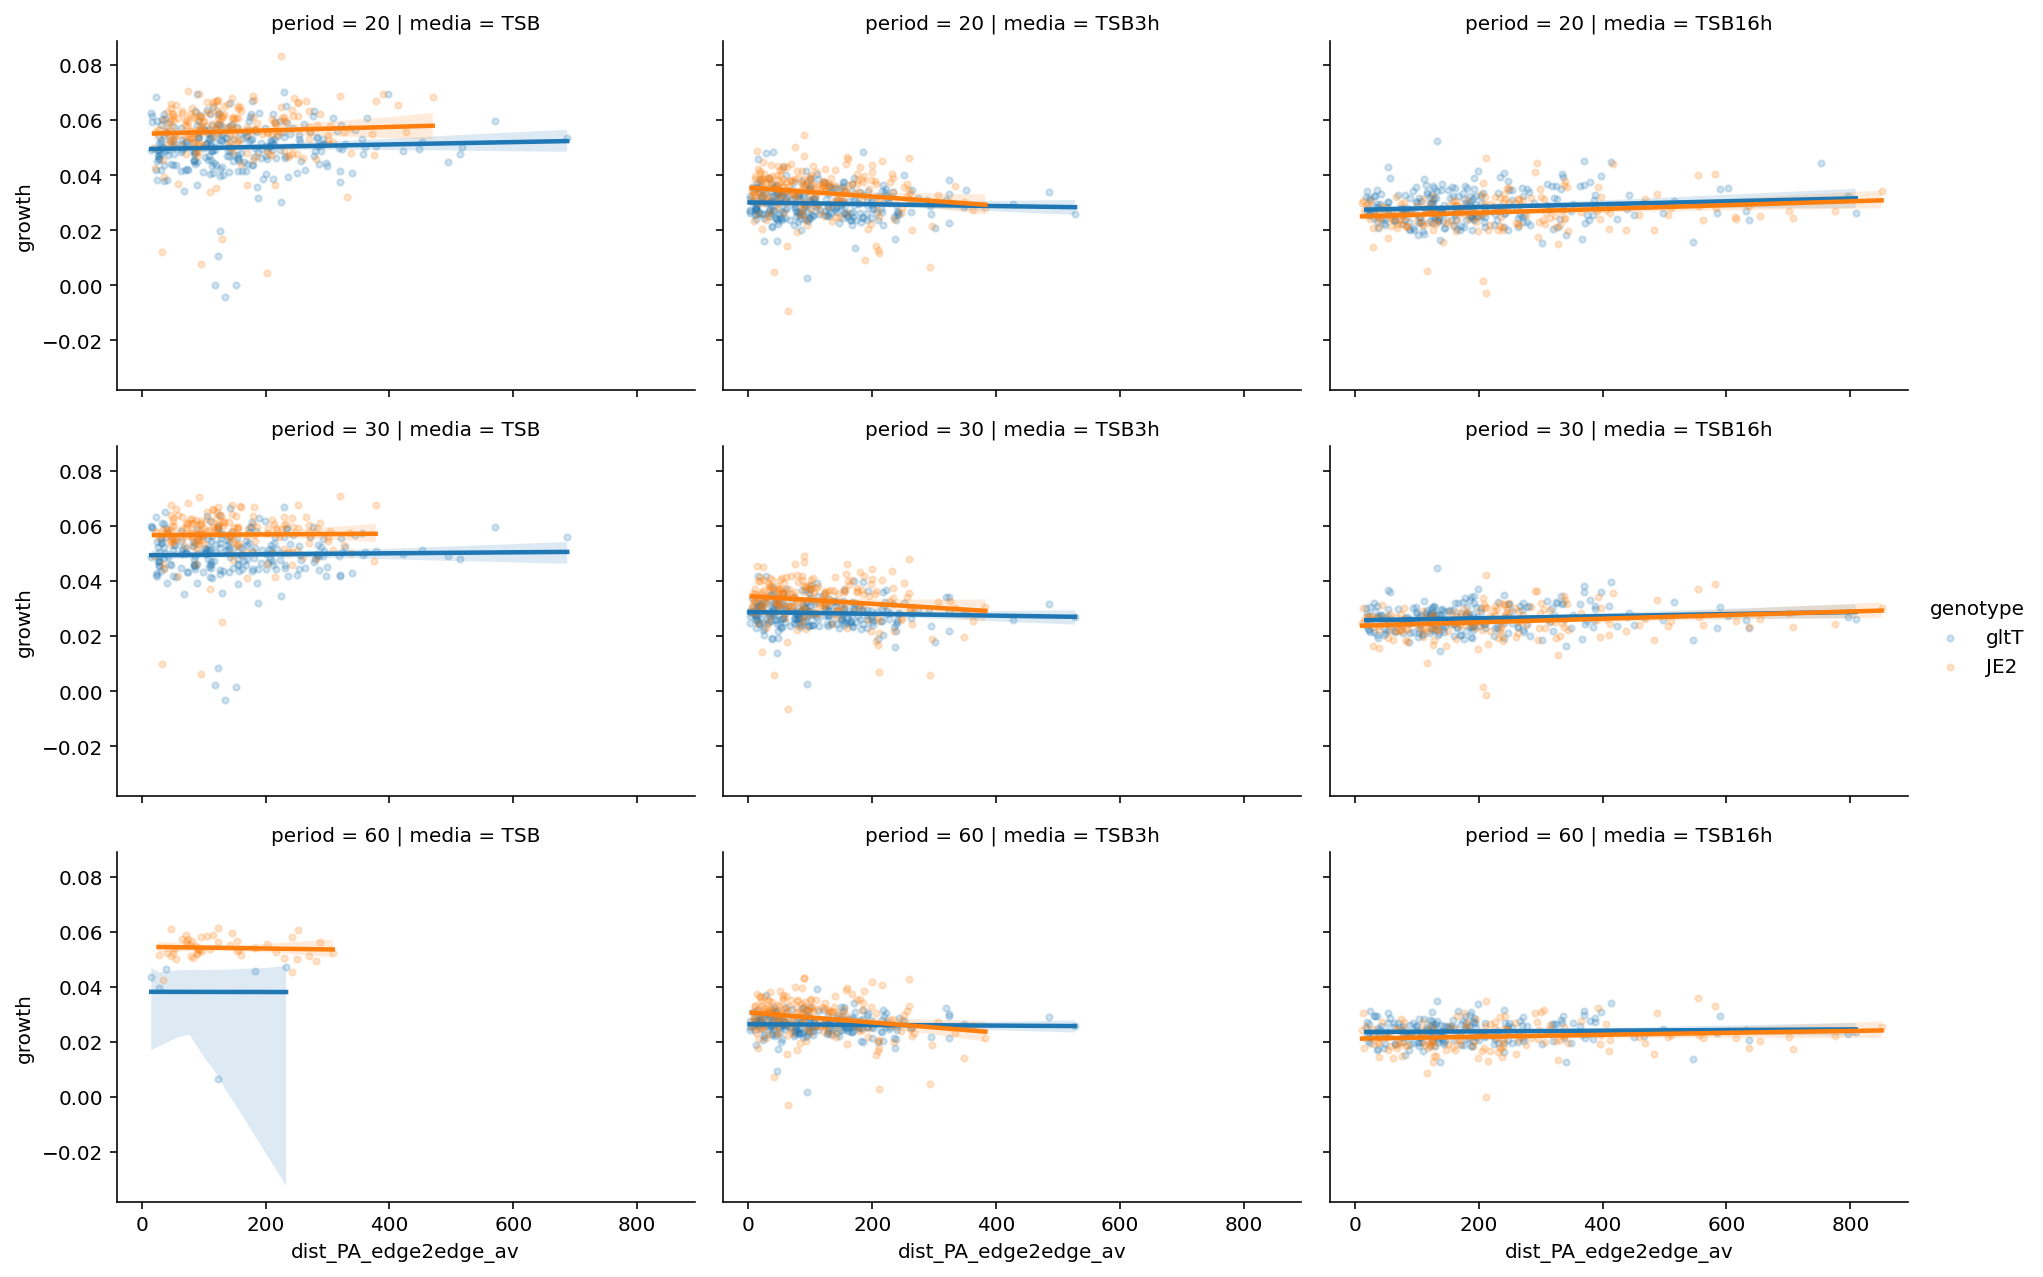

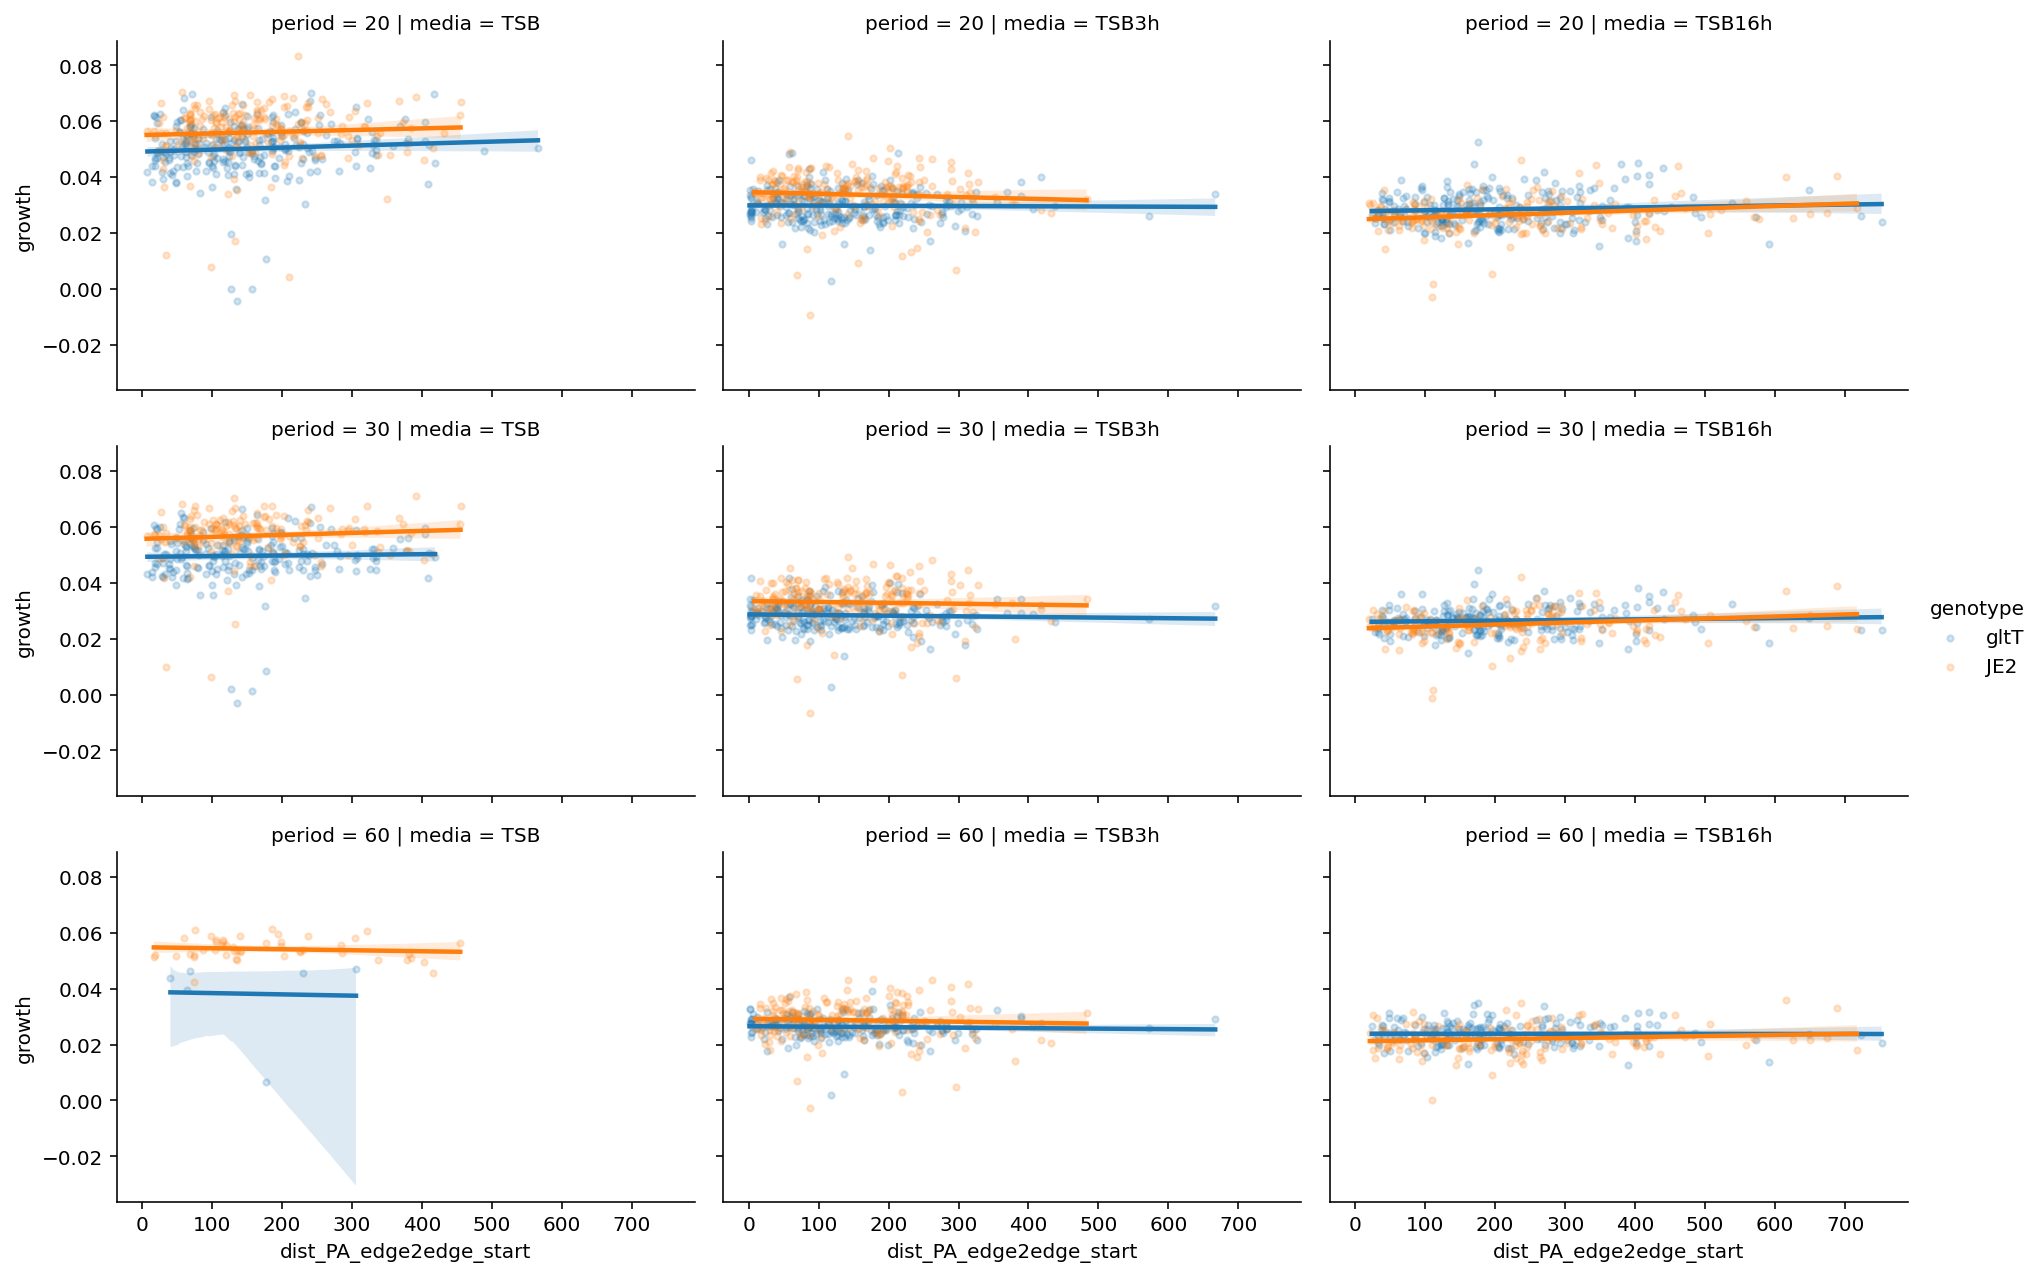

In [60]:
scat = {'s':10,'alpha':0.2}
aspect = 1.5
height = 3

sns.lmplot(data=df_summary, x='dist_PA_centroid_min', y='growth', col='media', row='period',hue='genotype', 
           scatter_kws=scat, aspect=aspect, height=height)

sns.lmplot(data=df_summary, x='dist_PA_centroid_av', y='growth', col='media', row='period',hue='genotype', 
           scatter_kws=scat, aspect=aspect, height=height)

sns.lmplot(data=df_summary, x='dist_PA_centroid_start', y='growth', col='media', row='period',hue='genotype', 
           scatter_kws=scat, aspect=aspect, height=height)

if 'dist_PA_edge2edge_min' in df_summary.columns:
    sns.lmplot(data=df_summary, x='dist_PA_edge2edge_min', y='growth', col='media', row='period',hue='genotype', 
               scatter_kws=scat, aspect=aspect, height=height)

if 'dist_PA_edge2edge_av' in df_summary.columns:
    sns.lmplot(data=df_summary, x='dist_PA_edge2edge_av', y='growth', col='media', row='period',hue='genotype', 
               scatter_kws=scat, aspect=aspect, height=height)
    
if 'dist_PA_edge2edge_start' in df_summary.columns:
    sns.lmplot(data=df_summary, x='dist_PA_edge2edge_start', y='growth', col='media', row='period',hue='genotype', 
               scatter_kws=scat, aspect=aspect, height=height)